Sihamdi Mostefa,Benaskeur moussabe

# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [28]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()
    

def gaussianKernel(sigma):
    N = np.int(np.ceil(3*sigma))
    x = y = np.linspace(np.int(-3*sigma),np.int(3*sigma),2*N+1)
    X,Y = np.meshgrid(x,y)
    noyau = np.exp(-(X*X+Y*Y)/(2*sigma*sigma))
    return noyau/noyau.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [38]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    det=np.zeros((256, 256))
    trace=np.zeros((256, 256))
    R=np.zeros((256, 256))
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    Ix=scipy.signal.convolve2d(image,Sx,'same')
    Iy=scipy.signal.convolve2d(image,Sy,'same')
    Ix_2=Ix*Ix
    Iy_2=Iy*Iy
    Ixy=Ix*Iy
    A=scipy.signal.convolve2d(Ix_2,gaussianKernel(scale),'same')
    B=scipy.signal.convolve2d(Iy_2,gaussianKernel(scale),'same')
    C=scipy.signal.convolve2d(Ixy,gaussianKernel(scale),'same')
    det=A*B-C**2
    trace=A+B
    R=det-kappa*(trace**2)
    return R
    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

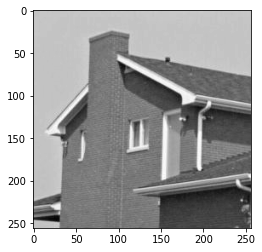

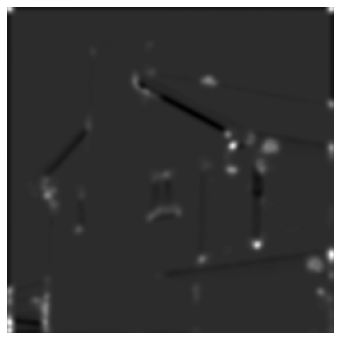

In [39]:
house2=np.array(Image.open('img/house2.png'))
plt.imshow(house2)

Harrishouse2=computeR(house2,2.3,0.04)
imshow(Harrishouse2)

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Corners are displayed in white (represent positive values), contours are in black (represent negative values) and homogeneous areas are displayed in gray (represent values close to zero). This allows us to differentiate them easily.

However there is a problem: contours and corners are detected at the edges of the image. This problem could be solved by using another technique to padding around the image.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

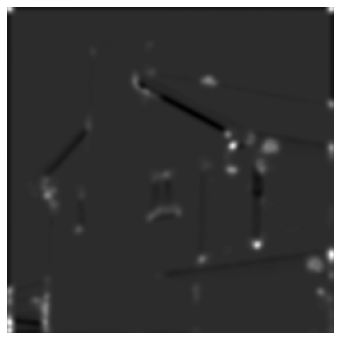

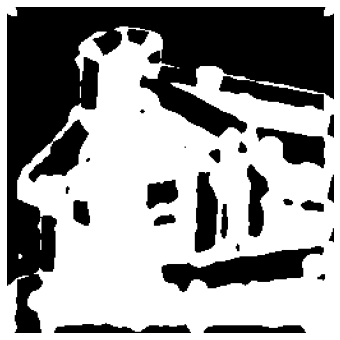

In [34]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return(np.where(R < thres, 0, 1))

imshow(Harrishouse2)
imshow(thresholdR(Harrishouse2,1000))
    

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

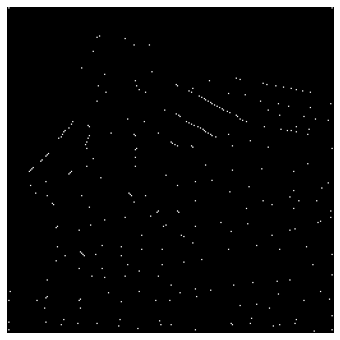

In [40]:
def rnms(image_harris,Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    left=np.greater(image_harris, np.roll(image_harris, 1, axis = 1))
    right=np.greater(image_harris, np.roll(image_harris, -1, axis = 1))
    up=np.greater(image_harris, np.roll(image_harris, 1, axis = 0))
    down=np.greater(image_harris, np.roll(image_harris, -1, axis = 0))
    rnm=np.zeros(image_harris.shape)
    for x in range(image_harris.shape[0]):
        for y in range(image_harris.shape[1]):
            if(left[x,y] and right[x,y] and up[x,y] and down[x,y] and Rbin[x,y]==1):
                rnm[x,y]=1
    
    return(rnm)
    
Rnmsup=rnms(Harrishouse2,thresholdR(Harrishouse2,10000))

imshow(Rnmsup)

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

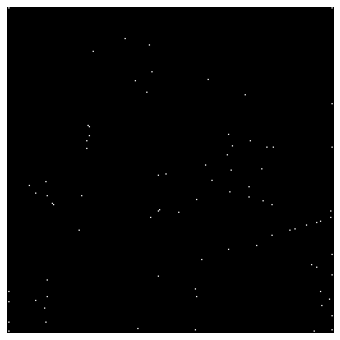

In [41]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    Harris=computeR(image,sigma,kappa)
    rnm=rnms(Harris,thresholdR(Harris,thres))
    return rnm

imshow(cornerDetector(house2,2.1,0.04,10000000))

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

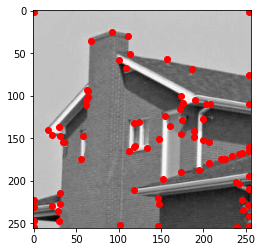

In [42]:
def displayCorner(image, sigma, kappa, thres):
    corner=cornerDetector(image,sigma,kappa,thres)
    nonzero=np.nonzero(corner)

    for x in range(0,len(nonzero),2):
        plt.scatter(nonzero[x+1],nonzero[x],c="r")
    plt.imshow(image)
    plt.show()

displayCorner(house2,2.1,0.04,10000000)

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

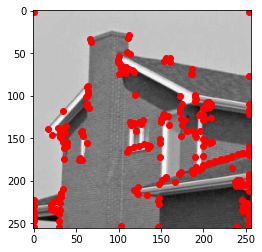

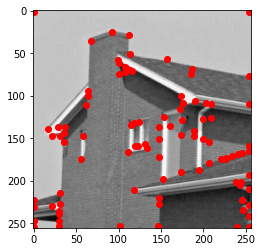

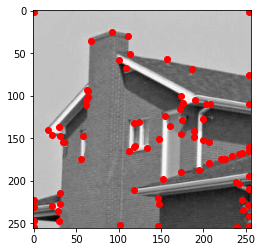

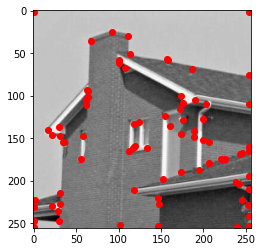

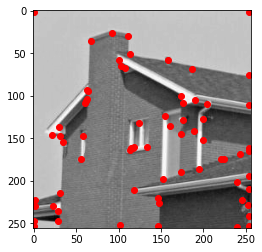

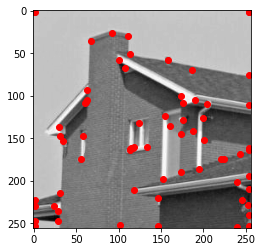

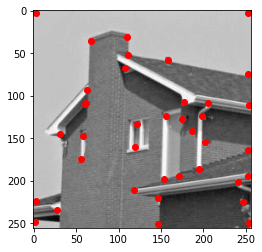

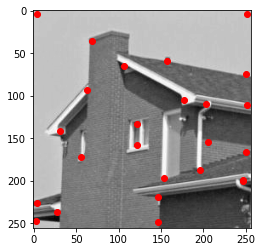

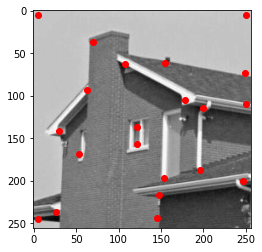

In [37]:
displayCorner(house2,1,0.04,10000000)
displayCorner(house2,2,0.04,10000000)
displayCorner(house2,2.1,0.04,10000000)
displayCorner(house2,2.2,0.04,10000000)
displayCorner(house2,2.5,0.04,10000000)
displayCorner(house2,3,0.04,10000000)
displayCorner(house2,5,0.04,10000000)
displayCorner(house2,8,0.04,10000000)
displayCorner(house2,10,0.04,10000000)

The detector seems to work best when sigma is close to 2, especially for sigma = 2.1 or sigma = 2.2.

The more the sigma value is increased, the more it detects the corners of large objects.

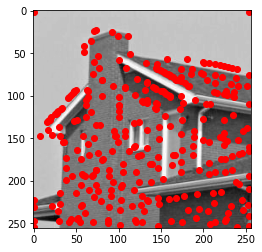

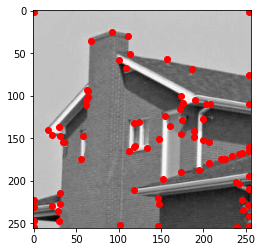

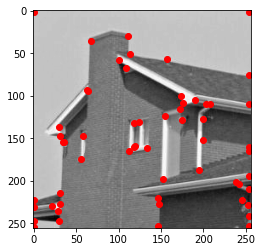

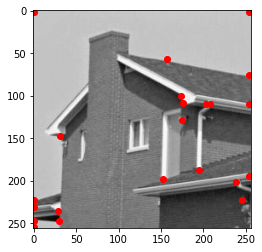

In [26]:
displayCorner(house2,2.1,0.04,10000)
displayCorner(house2,2.1,0.04,10000000)
displayCorner(house2,2.1,0.04,100000000)
displayCorner(house2,2.1,0.04,1000000000)

If the threshold is less than or equal to 10000 there are too many false positives, corners are detected where there are none. If the threshold is between 10000000 and 100000000, this seems acceptable: Most corners are detected and there are few false positives. If the threshold is greater than or equal to 1000000000 there are too many false negatives, the detector does not detect most corners.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

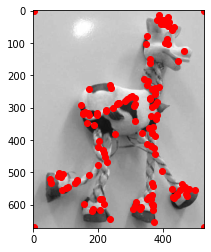

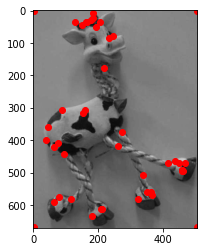

In [23]:
toyHorse1=np.array(Image.open('img/toyHorse1.png'))
toyHorse2=np.array(Image.open('img/toyHorse2.png'))
displayCorner(toyHorse1,2.1,0.04,100000000)
displayCorner(toyHorse2,2.1,0.04,100000000)

2) What are the dynamic ranges of these two images ?

In [69]:
print(np.amax(toyhorse1)-np.amin(toyhorse1))
print(np.amax(toyhorse2)-np.amin(toyhorse2))

254
253


The first image has a dynamic range of 254. The second image has a dynamic range of 253.

3) What are the transformations beetween the two images ?

There was a rotation between the first and second image. Moreover the angle of view is slightly different (the muzzle can be seen better on the second image than on the first one). Finally, although these 2 images have similar dynamics, the second one is much darker.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

By changing the rotation and changing the brightness, we notice that some points remain the same on the 2 images (especially the spots on the belly of the giraffe). However, the detection is not invariant because many more dots are present on the first image. This is probably due to the fact that this image is brighter, this could be remedied by adapting the threshold value according to the brightness of the image.